## Step 1: Import libraries

To start off, we will prepare an instatiation of all the required libraries for this analysis. While some of these libraries will be readily available, others will have to be explicitly installed either via pip, conda install, or directly through anaconda navigator.

In [8]:
import os
import requests
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import json, time, urllib.parse

## Step 2: Data Acquisition

As first step towards data analysis, we will first need to acquire all the required data from various sources. For this project, we will need to collect data through Pageviews API.
- Documentation: https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews
- Endpoint:  https://wikimedia.org/api/rest_v1/#/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end

The raw data to be collected is counts of pageviews using a specified subset of Wikipedia article pages. This subset is provided by a google spreadsheet detailing a large number of dinosaur related articles. https://docs.google.com/spreadsheets/d/1zfBNKsuWOFVFTOGK8qnTr2DmHkYK4mAACBKk1sHLt_k/edit


In the upcoming cells, we will be utilizing this example notebook: https://drive.google.com/file/d/1gtFZAjRoOShsqZKuNhiiSn9Ko4ky-CSC/view and make the API call to collect counts of pageviews of these listed dinosaur related articles in a series of steps.

In [ ]:
# Raw Data Upload
article = pd.read_csv('dinosaur.csv')

In [2]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': 'choubju1@uw.edu, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = list(article['name'])

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",             # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    
}

The parameters have been declared in the cell above. We will move on to declare a function that will make the API call utilizing the above mentioned parameters as required.

In [3]:
def request_pageviews_per_article(article_title = None,
                                  access=None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    request_template['access'] = access
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)

    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
        
    except Exception as e:
        print(e)
        json_response = None
    return json_response

The utility to perform data acquisition is prepared. We will now begin to utilize this utility and acquire the 3 data files as we need.

#### File 1: Monthly Desktop Access

Call *request_pageviews_per_article* for every article present in the article file with access type as *'dekstop'*. The response will be captured within a JSON file.

In [4]:
filename = 'dino_monthly_desktop_201507-202209.json'
listObj = []
for i in ARTICLE_TITLES:
    views = request_pageviews_per_article(i,'desktop')
    for month in views['items']:
        listObj.append(month)
    with open(filename, 'w') as json_file:
        json.dump(listObj, json_file, 
                        indent=4,  
                        separators=(',',': '))

#### File 2: Monthly Mobile Access

Call *request_pageviews_per_article* twice:
- once for access type as 'mobile-web', and 
- once for access type as 'mobile-app'. 

Traffic for these 2 access types are consolidated and the output is written in a json file with access type 'mobile'.

In [5]:
filename = 'dino_monthly_mobile_201507-202209.json'
listObjMobile = []
for i in ARTICLE_TITLES:
    viewsApp = request_pageviews_per_article(i,"mobile-app")
    viewsWeb = request_pageviews_per_article(i,"mobile-web")
    viewsMobile = viewsApp
    for month in viewsWeb['items']:
        ts = month['timestamp']
        vs = month['views']
        for m in viewsMobile['items']:
            if m['timestamp']==ts:
                m['views']+=vs
                m['access']='mobile'

    for month in viewsMobile['items']:
        listObjMobile.append(month)
    with open(filename, 'w') as json_file:
        json.dump(listObjMobile, json_file, 
                        indent=4,  
                        separators=(',',': '))

#### File 3: Monthly cumulative

Call *request_pageviews_per_article* for every article present in the article subset file for *'all-access'* access type. The response is captured in a JSON file. The data in the file is read in a data frame, the cumulative sum of views is calculated before saving the final data in the required JSON format.

In [6]:
filename = 'all_access_data.json'
listObjCumulative = []
for i in ARTICLE_TITLES:
    viewsCumulative = request_pageviews_per_article(i,"all-access")
    for month in viewsCumulative['items']:
        listObjCumulative.append(month)
    with open(filename, 'w') as json_file:
        json.dump(listObjCumulative, json_file, 
                        indent=4,  
                        separators=(',',': '))
        
data_cumulative = pd.read_json('all_access_data.json',convert_dates=False)
data_cumulative.views = data_cumulative.views.cumsum()
data_cumulative.to_json('dino_monthly_cumulative_201507-202209.json', orient='records')

## Step 3: Data Analysis

We will now conduct the requested analysis: graph specific subsets of the three data sets as a timeseries. Before diving into the three graphs, we will import the datasets and perform standard timestamp formatting for the date columns.

In [10]:
def preprocess(df):
    df.timestamp = df.timestamp/100
    df.timestamp = pd.to_datetime(df.timestamp,format="%Y%m%d")
    return df

df_desktop = pd.read_json('dino_monthly_desktop_201507-202209.json',convert_dates=False)
df_mobile = pd.read_json('dino_monthly_mobile_201507-202209.json',convert_dates=False)
df_desktop,df_mobile = map(preprocess,[df_desktop,df_mobile])

### Graph 1: Maximum Average and Minimum Average

**Objective:** The first graph should contain time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access. The graph should have four lines (max desktop, min desktop, max mobile, min mobile).

**Process:** movingAverage() function is created to calculate the average views for every dinosaur. It then append the names of the dinosaus with the maximum and minimum average traffic over the given period. This function is executed twice for the two access types.

In [18]:
def movingAverage(df):
    list_dino=[]
    avg_views = df.groupby('article',as_index=False)['views'].mean()
    list_dino.append(avg_views.loc[avg_views['views'] == max(avg_views['views']),['article']].iloc[0][0])
    list_dino.append(avg_views.loc[avg_views['views'] == min(avg_views['views']),['article']].iloc[0][0])
    return list_dino

list_dino_combined = []
list_dino_combined.extend(movingAverage(df_desktop))
list_dino_combined.extend(movingAverage(df_mobile))

list_dino_combined = list(set(list_dino_combined))
print("1. Desktop\n    Dinosaurs with Max and Min average views:", list_dino_combined)
print("\n2. Mobile\n    Dinosaurs with Max and Min average views:", list_dino_combined)

1. Desktop
    Dinosaurs with Max and Min average views: ['Tyrannosaurus', 'Honghesaurus']

2. Mobile
    Dinosaurs with Max and Min average views: ['Tyrannosaurus', 'Honghesaurus']


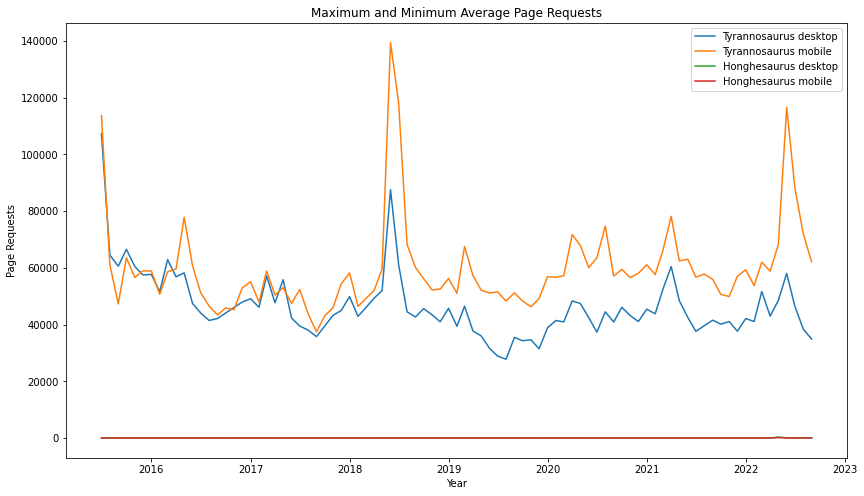

In [19]:
# Plotting the graph

fig = plt.figure(figsize=(14, 8))
for a in list_dino_combined:
    plt.plot(df_desktop.loc[df_desktop.article==a,'timestamp'],df_desktop.loc[df_desktop.article==a,'views'],label=a+' desktop')
    plt.plot(df_mobile.loc[df_mobile.article==a,'timestamp'],df_mobile.loc[df_mobile.article==a,'views'],label=a+' mobile')
plt.title("Maximum and Minimum Average Page Requests")
plt.xlabel("Year")
plt.ylabel("Page Requests")
plt.legend()
plt.savefig("maximum_minimum_average.png", facecolor='white')
plt.show()

### Graph 2: Top 10 Peak Page Views

**Objective:** The second graph should contain time series for the top 10 article pages by largest (peak) page views over the entire time by access type. First, find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. The graph should contain the top 10 for desktop and top 10 for mobile access (20 lines).

**Process:** We will follow the exact steps as listed in the objective.

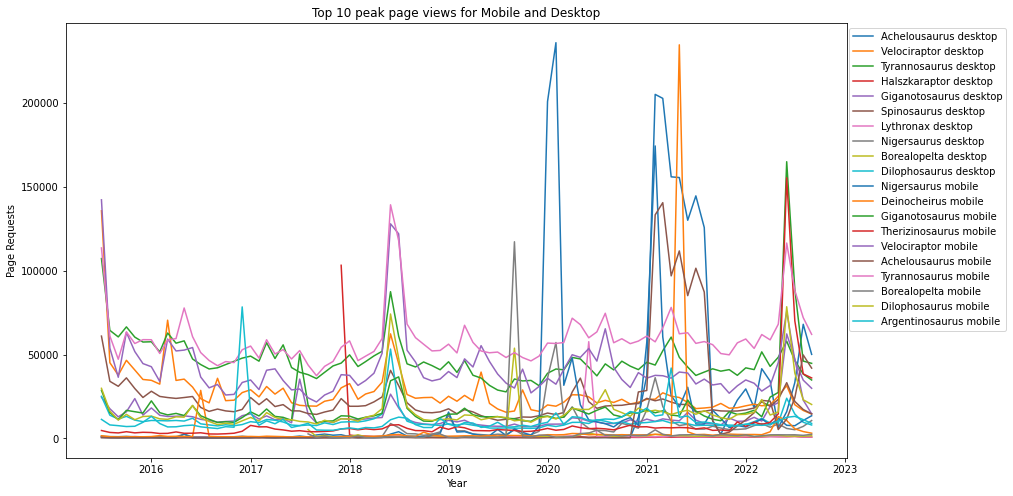

In [20]:
desktop_peak_views = df_desktop.iloc[df_desktop.groupby(["article"],as_index=False)["views"].idxmax()['views']]
dino_list_desktop = desktop_peak_views.sort_values('views',ascending=False).article.head(10).tolist()

mobile_peak_views = df_mobile.iloc[df_mobile.groupby(["article"],as_index=False)["views"].idxmax()['views']]
dino_list_mobile = mobile_peak_views.sort_values('views',ascending=False).article.head(10).tolist()

# Plotting the graph

fig = plt.figure(figsize=(14, 8))
for a in dino_list_desktop:
    plt.plot(df_desktop.loc[df_desktop.article==a,'timestamp'],df_desktop.loc[df_desktop.article==a,'views'],label=a+" desktop")
for a in dino_list_mobile:
    plt.plot(df_mobile.loc[df_mobile.article==a,'timestamp'],df_mobile.loc[df_mobile.article==a,'views'],label=a+" mobile")
plt.title("Top 10 peak page views for Mobile and Desktop")
plt.xlabel("Year")
plt.ylabel("Page Requests")
plt.legend(loc='upper right',bbox_to_anchor=(1.21, 1))
plt.savefig("top_10_peak_page_views.png", facecolor='white')
plt.show()

### Graph 3: Fewest Months of Data

**Objective:** The third graph should show pages that have the fewest months of available data. These will all be relatively short time series, some may only have one month of data. The graph should show the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

**Process:** We will follow the exact steps as listed in the objective.

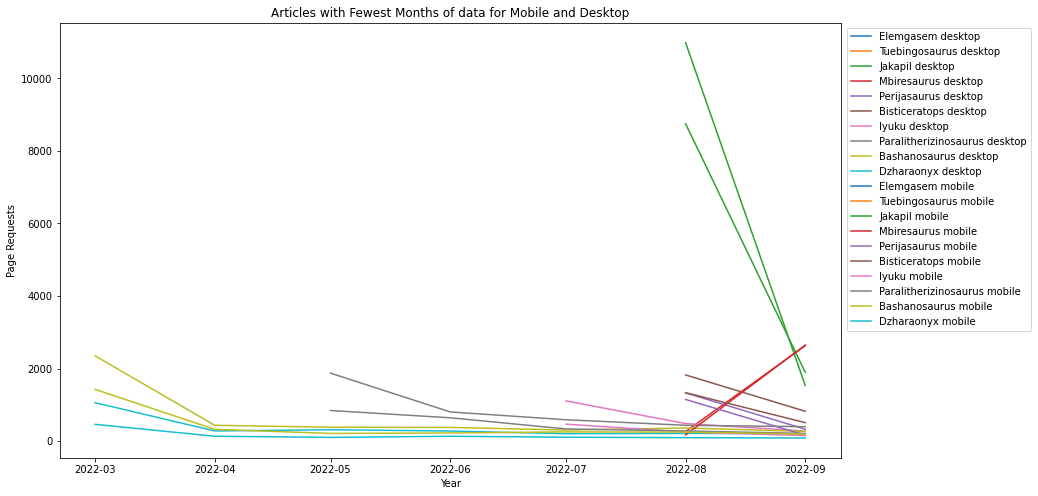

In [21]:
desktop_month_count = df_desktop.groupby(["article"],as_index=False).size()
dino_list_desktop_month_count = desktop_month_count.sort_values('size',ascending=True).article.head(10).tolist()

mobile_month_count = df_mobile.groupby(["article"],as_index=False).size()
dino_list_mobile_month_count = mobile_month_count.sort_values('size',ascending=True).article.head(10).tolist()

## Ploting the graph
fig = plt.figure(figsize=(14, 8))
for a in dino_list_desktop_month_count:
    plt.plot(df_desktop.loc[df_desktop.article==a,'timestamp'],df_desktop.loc[df_desktop.article==a,'views'],label=a+' desktop')
for a in dino_list_mobile_month_count:
    plt.plot(df_mobile.loc[df_mobile.article==a,'timestamp'],df_mobile.loc[df_mobile.article==a,'views'],label = a+' mobile')
plt.title("Articles with Fewest Months of data for Mobile and Desktop")
plt.xlabel("Year")
plt.ylabel("Page Requests")
plt.legend(loc='upper right',bbox_to_anchor=(1.25, 1))
plt.savefig("fewest_month_views.png", facecolor='white')
plt.show()

This completes the data analysis part of the exercise.